In [46]:
import os, sys
import sys
import numpy as np
from scipy import signal
from  matplotlib import pyplot as plt
import librosa
from scipy import signal
import IPython.display as ipd
import pandas as pd
sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
from numba import jit

%matplotlib inline
      
  
    

## https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S1_OnsetDetection.html

In [2]:
def plot_wav_spectrogram(fn_wav, xlim=None, audio=True):
    """Plot waveform and computed spectrogram and may display audio
    Notebook: C6/C6S1_OnsetDetection.ipynb
    """
    Fs = 22050
    x, Fs = librosa.load(fn_wav, Fs) 
    plt.figure(figsize=(8,2)) 
    ax = plt.subplot(1,2,1)
    libfmp.b.plot_signal(x, Fs, ax=ax)
    if xlim!=None: plt.xlim(xlim)
    ax = plt.subplot(1,2,2)
    N, H = 512, 256 
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Y = np.log(1 + 10 * np.abs(X))
    libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax], colorbar=False)
    plt.ylim([0,5000])
    if xlim is not None: plt.xlim(xlim)
    plt.tight_layout()
    plt.show()
    if audio: ipd.display(ipd.Audio(x, rate=Fs))


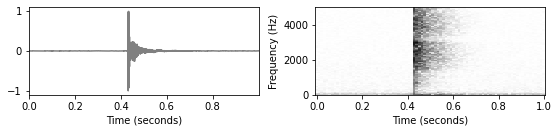

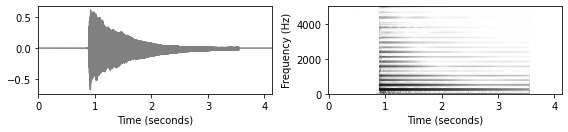

In [4]:
fn_wav = os.path.join('.', 'data', 'C6', 'FMP_C6_F04_Impulse.wav')
plot_wav_spectrogram(fn_wav)

fn_wav = os.path.join('.', 'data', 'C6', 'FMP_C6_F04_NoteC4_Piano.wav')
plot_wav_spectrogram(fn_wav)

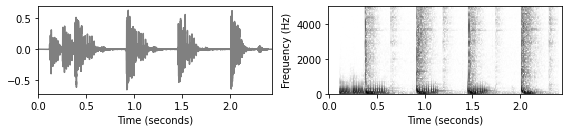

In [13]:
fn_wav = os.path.join('.', 'data', 'C6', 'FMP_C6_F01_Queen.wav')
plot_wav_spectrogram(fn_wav, audio=False)

In [14]:
fn_wav

'.\\data\\C6\\FMP_C6_F01_Queen.wav'

In [8]:
def read_annotation_pos(fn_ann, label='', header=True, print_table=False):
    """Read and convert file containing either list of pairs (number,label) or list of (number)

    Notebook: C6/C6S1_OnsetDetection.ipynb

    Args:
        fn_ann (str): Name of file
        label (str): Name of label (Default value = '')
        header (bool): Assumes header (True) or not (False) (Default value = True)
        print_table (bool): Prints table if True (Default value = False)

    Returns:
        ann (list): List of annotations
        label_keys (dict): Dictionaries specifying color and line style used for labels
    """
    df = libfmp.b.read_csv(fn_ann, header=header)
    if print_table:
        print(df)
    num_col = df.values[0].shape[0]
    if num_col == 1:
        df = df.assign(label=[label] * len(df.index))
    ann = df.values.tolist()

    label_keys = {'beat': {'linewidth': 2, 'linestyle': ':', 'color': 'r'},
                  'onset': {'linewidth': 1, 'linestyle': ':', 'color': 'r'}}
    return ann, label_keys



In [12]:
print(fn_wav)

..\data\C6\FMP_C6_F01_Queen.wav


   position  label
0  0.117460  onset
1  0.247619  onset
2  0.372698   beat
3  0.646349  onset
4  0.911111   beat
5  1.184762  onset
6  1.445442   beat
7  1.735238  onset
8  2.000000   beat
9  2.287619  onset
Name of wav .\data\C6\FMP_C6_F01_Queen.wav
Duration 2.4304308390022675


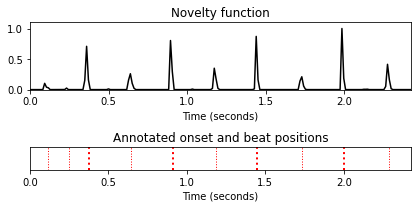

In [15]:
fn_ann = os.path.join('.', 'data', 'C6', 'FMP_C6_F01_Queen.csv')
ann, label_keys = read_annotation_pos(fn_ann, print_table=True)

print("Name of wav", fn_wav)
x, Fs = librosa.load(fn_wav)
x_duration = len(x)/Fs
print("Duration", x_duration)
nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6, 3))
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0], color='k', title='Novelty function');
libfmp.b.plot_annotation_line(ann, ax=ax[1], label_keys=label_keys,
                    time_min=0, time_max=x_duration)
ax[1].set_title('Annotated onset and beat positions')
ax[1].set_xlabel('Time (seconds)')

plt.tight_layout()

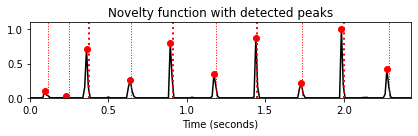

In [16]:
peaks, properties = signal.find_peaks(nov, prominence=0.02)
T_coef = np.arange(nov.shape[0]) / Fs_nov
peaks_sec = T_coef[peaks]
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', 
                    title='Novelty function with detected peaks')
libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys, 
                    nontime_axis=True, time_min=0, time_max=x_duration)
plt.plot(peaks_sec, nov[peaks], 'ro')
plt.show()

x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

## https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S1_NoveltyEnergy.html

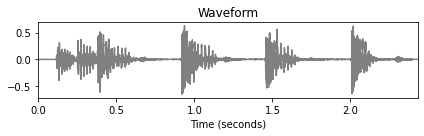

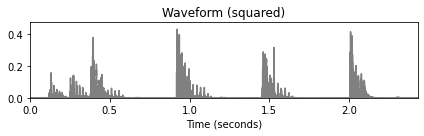

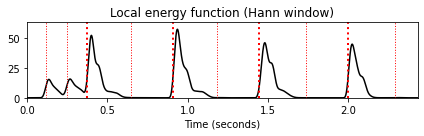

In [18]:
fn_ann = os.path.join('.', 'data', 'C6', 'FMP_C6_F01_Queen.csv')
ann, label_keys = libfmp.c6.read_annotation_pos(fn_ann)

fn_wav = os.path.join('.', 'data', 'C6', 'FMP_C6_F01_Queen.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 
x_duration = len(x)/Fs

N = 2048
w = signal.hann(N)

#Calculate local energy
x_square = x**2
energy_local = np.convolve(x_square, w**2, 'same')

libfmp.b.plot_signal(x, Fs, title='Waveform')
libfmp.b.plot_signal(x_square, Fs, title='Waveform (squared)')
fig, ax, line = libfmp.b.plot_signal(energy_local, Fs, color='k', 
                    title='Local energy function (Hann window)')
libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.tight_layout()

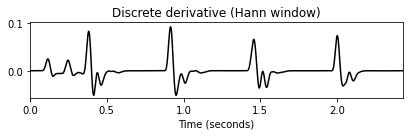

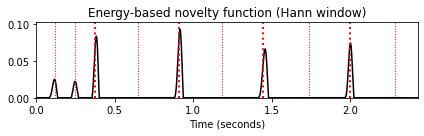

In [19]:
#Differentiation and half-wave rectification
energy_local_diff = np.diff(energy_local)
energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
novelty_energy = np.copy(energy_local_diff)
novelty_energy[energy_local_diff < 0] = 0

libfmp.b.plot_signal(energy_local_diff, Fs, color='k', 
                    title='Discrete derivative (Hann window)')
fig, ax, line = libfmp.b.plot_signal(novelty_energy, Fs, color='k',
                    title='Energy-based novelty function (Hann window)')
libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.tight_layout()

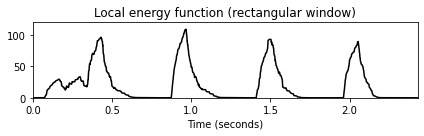

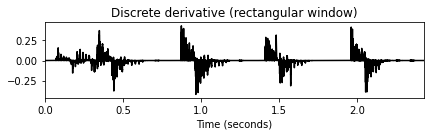

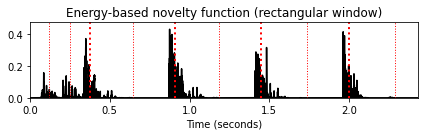

In [20]:
# Use rectangular window
w = signal.boxcar(N)
x_square = x**2
energy_local = np.convolve(x_square, w**2, 'same')
energy_local_diff = np.diff(energy_local)
energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
novelty_energy = np.copy(energy_local_diff)
novelty_energy[energy_local_diff < 0] = 0

fig, ax, line = libfmp.b.plot_signal(energy_local, Fs, color='k',
                    title='Local energy function (rectangular window)')
libfmp.b.plot_signal(energy_local_diff, Fs, color='k', 
                    title='Discrete derivative (rectangular window)')
fig, ax, line = libfmp.b.plot_signal(novelty_energy, Fs, color='k', title='Energy-based novelty function (rectangular window)')
libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.tight_layout()

In [21]:
def compute_novelty_energy(x, Fs=1, N=2048, H=128, gamma=10.0, norm=True):
    """Compute energy-based novelty function

    Notebook: C6/C6S1_NoveltyEnergy.ipynb

    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate (Default value = 1)
        N (int): Window size (Default value = 2048)
        H (int): Hop size (Default value = 128)
        gamma (float): Parameter for logarithmic compression (Default value = 10.0)
        norm (bool): Apply max norm (if norm==True) (Default value = True)

    Returns:
        novelty_energy (np.ndarray): Energy-based novelty function
        Fs_feature (scalar): Feature rate
    """
    # x_power = x**2
    w = signal.hann(N)
    Fs_feature = Fs / H
    energy_local = np.convolve(x**2, w**2, 'same')
    energy_local = energy_local[::H]
    if gamma is not None:
        energy_local = np.log(1 + gamma * energy_local)
    energy_local_diff = np.diff(energy_local)
    energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
    novelty_energy = np.copy(energy_local_diff)
    novelty_energy[energy_local_diff < 0] = 0
    if norm:
        max_value = max(novelty_energy)
        if max_value > 0:
            novelty_energy = novelty_energy / max_value
    return novelty_energy, Fs_feature

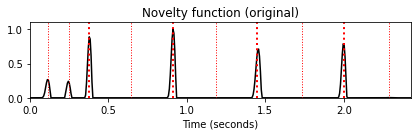

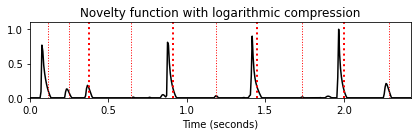

In [22]:
N = 2048
H = 128
nov_1, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, H=H, gamma=None)
nov_2, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, H=H, gamma=1000)

fig, ax, line = libfmp.b.plot_signal(nov_1, Fs=Fs_nov, color='k', 
                    title='Novelty function (original)')
libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
fig, ax, line = libfmp.b.plot_signal(nov_2, Fs=Fs_nov, color='k',
                    title='Novelty function with logarithmic compression')
libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);

Duration 105.37115646258503
Sampling frequency 22050


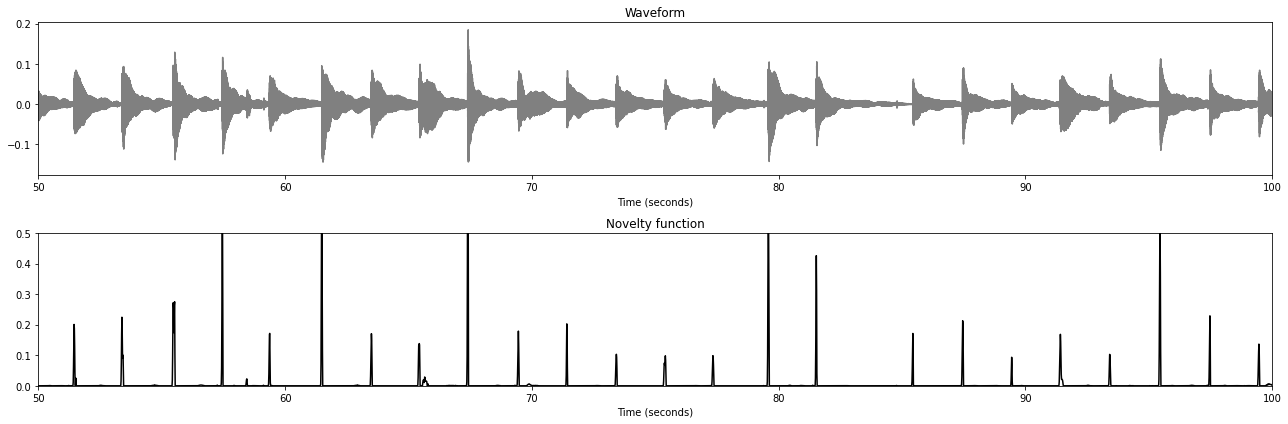

In [45]:
start_time = 50
stop_time = 100

fn_wav = os.path.join('.', 'data', 'Rusen','Closed.wav')
x, Fs = librosa.load(fn_wav)
x_duration = len(x)/Fs
print("Duration", x_duration)
print("Sampling frequency", Fs)
N = 2048
H = 256
nov, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, H=H, gamma=None)

plt.figure(figsize=(18,6))
ax = plt.subplot(2,1,1)
fig, ax, line = libfmp.b.plot_signal(x, Fs, ax = ax, title='Waveform')

plt.xlim([start_time, stop_time]);

ax = plt.subplot(2,1,2)
fig, ax, line = libfmp.b.plot_signal(nov, Fs=Fs_nov, ax = ax, color='k', 
                     title='Novelty function')

plt.ylim([0, 0.5])
plt.xlim([start_time, stop_time]);
plt.tight_layout()

## https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S1_NoveltySpectral.html

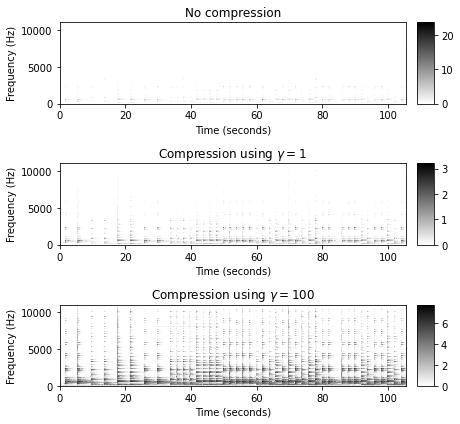

In [130]:
#fn_wav = os.path.join('.', 'data', 'C6', 'FMP_C6_F01_Queen.wav')

fn_wav = os.path.join('.', 'data', 'Rusen','ClosedDub4.wav')

Fs = 22050
x, Fs = librosa.load(fn_wav, Fs)
x_duration = len(x)/Fs
N, H = 1024, 256
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 1, 1]}, figsize=(6.5, 6))        

Y = np.abs(X)
libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[0,0], ax[0,1]], title='No compression')

gamma = 1
Y = np.log(1 + gamma * np.abs(X))
libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[1,0], ax[1,1]], title='Compression using $\gamma=%0.0f$'%gamma)

gamma = 100
Y = np.log(1 + gamma * np.abs(X))
libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[2,0], ax[2,1]], title='Compression using $\gamma=%0.0f$'%gamma)
plt.tight_layout()

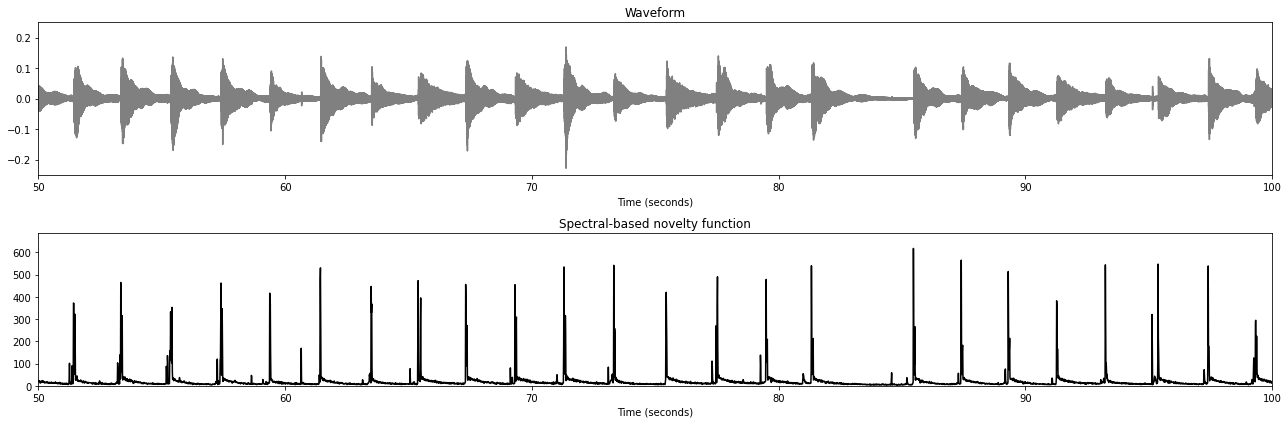

In [101]:
start_time = 50
stop_time = 100

Y = np.log(1 + 100 * np.abs(X))
Y_diff = np.diff(Y, n=1)
Y_diff[Y_diff < 0] = 0
nov = np.sum(Y_diff, axis=0)
nov = np.concatenate((nov, np.array([0])))
Fs_nov = Fs/H

plt.figure(figsize=(18,6))
ax = plt.subplot(2,1,1)
fig, ax, line = libfmp.b.plot_signal(x, Fs, ax = ax, title='Waveform')

plt.xlim([start_time, stop_time]);


ax = plt.subplot(2,1,2)
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', ax=ax,  title='Spectral-based novelty function')


plt.xlim([start_time, stop_time]);
plt.tight_layout()



In [49]:
def compute_local_average(x, M):
    """Compute local average of signal

    Notebook: C6/C6S1_NoveltySpectral.ipynb

    Args:
        x (np.ndarray): Signal
        M (int): Determines size (2M+1) in samples of centric window  used for local average

    Returns:
        local_average (np.ndarray): Local average signal
    """
    L = len(x)
    local_average = np.zeros(L)
    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    return local_average




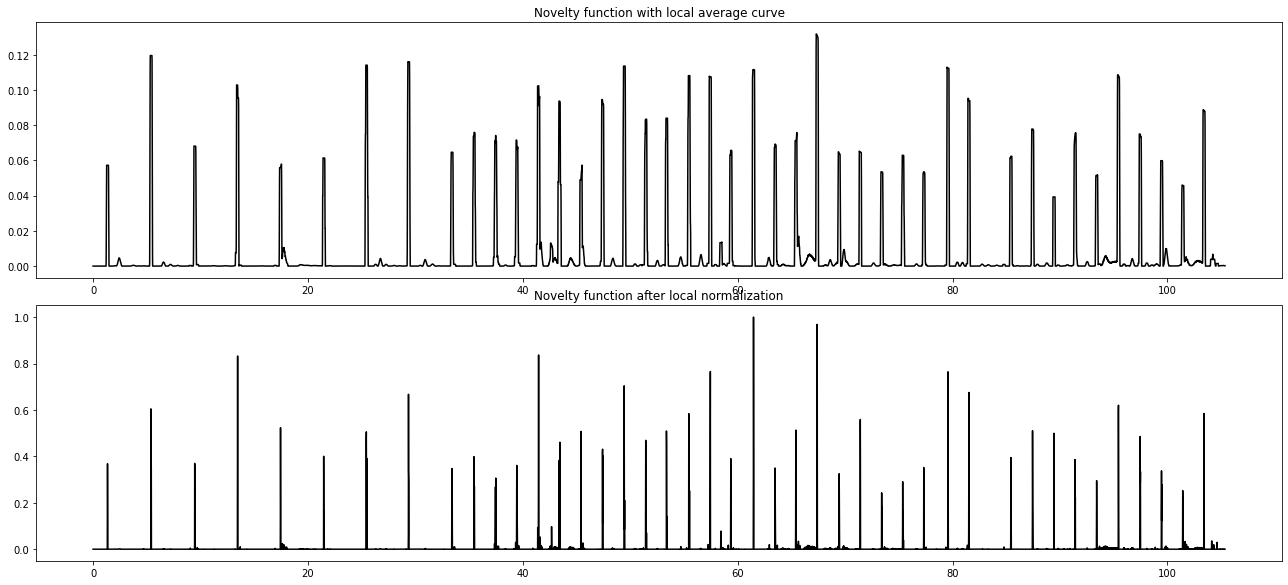

In [80]:
M_sec = 0.1
M = int(np.ceil(M_sec * Fs_nov))

local_average = compute_local_average(nov, M)
nov_norm =  nov - local_average
nov_norm[nov_norm<0]=0
nov_norm = nov_norm / max(nov_norm)
t_novelty = np.arange(nov.shape[0]) / Fs_nov

plt.figure(figsize=(18,8))
ax = plt.subplot(2,1,1)
plt.plot(t_novelty, local_average, 'k')
plt.title('Novelty function with local average curve')
plt.tight_layout()

ax = plt.subplot(2,1,2)
plt.plot(t_novelty, nov_norm,  'k')
plt.title('Novelty function after local normalization');





In [52]:
def compute_novelty_spectrum(x, Fs=1, N=1024, H=256, gamma=100.0, M=10, norm=True):
    """Compute spectral-based novelty function

    Notebook: C6/C6S1_NoveltySpectral.ipynb

    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate (Default value = 1)
        N (int): Window size (Default value = 1024)
        H (int): Hop size (Default value = 256)
        gamma (float): Parameter for logarithmic compression (Default value = 100.0)
        M (int): Size (frames) of local average (Default value = 10)
        norm (bool): Apply max norm (if norm==True) (Default value = True)

    Returns:
        novelty_spectrum (np.ndarray): Energy-based novelty function
        Fs_feature (scalar): Feature rate
    """
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Fs_feature = Fs / H
    Y = np.log(1 + gamma * np.abs(X))
    Y_diff = np.diff(Y)
    Y_diff[Y_diff < 0] = 0
    novelty_spectrum = np.sum(Y_diff, axis=0)
    novelty_spectrum = np.concatenate((novelty_spectrum, np.array([0.0])))
    if M > 0:
        local_average = compute_local_average(novelty_spectrum, M)
        novelty_spectrum = novelty_spectrum - local_average
        novelty_spectrum[novelty_spectrum < 0] = 0.0
    if norm:
        max_value = max(novelty_spectrum)
        if max_value > 0:
            novelty_spectrum = novelty_spectrum / max_value
    return novelty_spectrum, Fs_feature

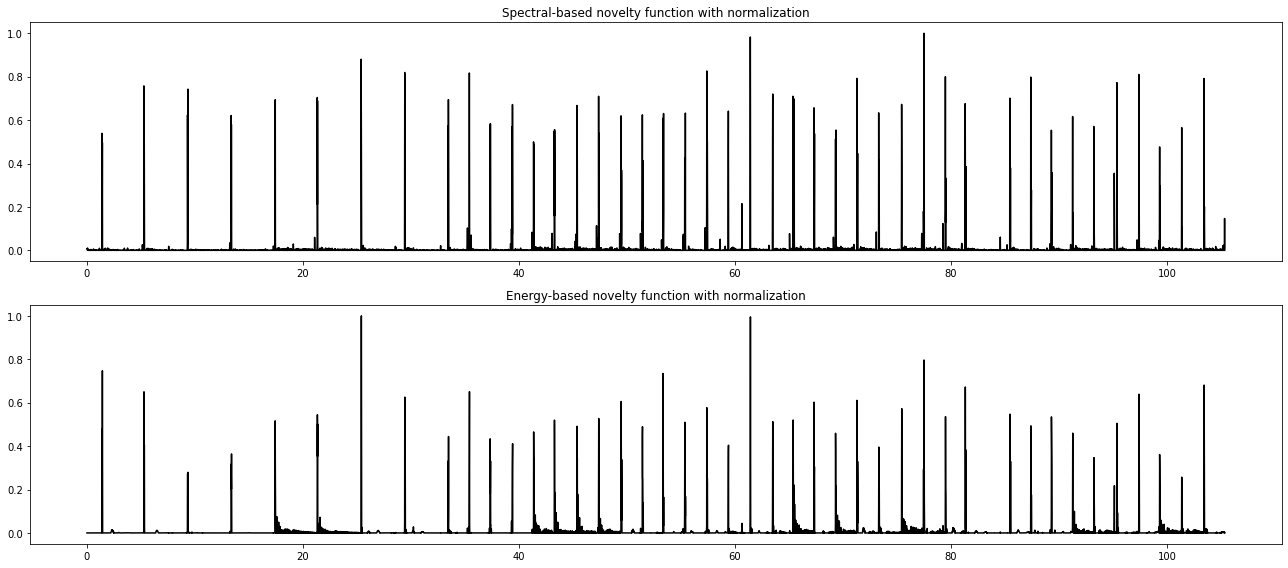

In [131]:
nov_spectrum, Fs_nov = compute_novelty_spectrum(x, Fs=Fs, N=1024, H=256, gamma=10, M=10, norm=True)
plt.figure(figsize=(18,8))

ax = plt.subplot(2,1,1)
plt.plot(t_novelty, nov_spectrum, 'k')
plt.title('Spectral-based novelty function with normalization')



nov_energy, Fs_nov = libfmp.c6.compute_novelty_energy(x, Fs=Fs, N=1024, H=256, gamma=10)
ax = plt.subplot(2,1,2)
plt.plot(t_novelty, nov_energy, 'k')
plt.title('Energy-based novelty function with normalization')
plt.tight_layout()



In [132]:
data_to_be_written_sv = [t_novelty , nov_energy , nov_spectrum]
sv_df = pd.DataFrame (data_to_be_written_sv).transpose()
sv_df.to_csv("NoveltyClosedDub4.csv", index=False, header=False)